In [1]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scanpy as sc
import pandas as pd
import numpy as np
import os
import re

### Load the files from the directory

In [2]:
Path = "/QRISdata/Q2051/STimage_project/TCGA_pred/"

def get_filenames_in_directory(directory_path):
    h5_filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".h5ad") and os.path.isfile(os.path.join(directory_path, filename)):
            h5_filenames.append(filename)
    return h5_filenames

def TCGA_name(original_array):
    result_array = []
    for item in original_array:
        parts = item.split("_")
        if len(parts) >= 2:
            second_part = parts[1].split(".")[0]
            result_array.append(second_part)
    pattern1 = re.compile(r'-\d+-\w+$')
    pattern2 = re.compile(r'(.+)-\w+-\d+-\w+$')
    name_info = [re.sub(pattern1, '', s) for s in result_array]
    name_surv_info = [re.sub(pattern2, r'\1', s) for s in result_array]   
    return name_info, name_surv_info

### Align the bulk and predicted gene expression with the clinical information

In [ ]:
filenames = get_filenames_in_directory(Path)
name_info, name_surv_info = TCGA_name(filenames)
final_gene_counts = pd.DataFrame()
final_gene_mean_counts = pd.DataFrame()
for i in tqdm(range(len(filenames)), desc="Processing files"):
    try:
        adata = sc.read_h5ad(Path + filenames[i])
        gene_counts = adata.to_df()
        gene_counts.index = [name_info[i]] * len(gene_counts)
        gene_counts_mean = pd.DataFrame(gene_counts.mean(axis=0))
        final_gene_counts = pd.concat([final_gene_counts, gene_counts])
        final_gene_mean_counts = pd.concat([final_gene_mean_counts, gene_counts_mean.T])
    except:
        print("File empty:",Path + filenames[i])
        del name_info[i]

final_gene_mean_counts.index = name_info

final_gene_counts.to_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_final_gene_counts.csv")
final_gene_mean_counts.to_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_final_gene_mean_counts.csv")

##############################################################################################################################

survival_info = pd.read_excel("/scratch/project/stseq/Onkar/STimage_v1/Survival/STimage_TCGA_patients.xlsx")
sample_info = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/gdc_sample_sheet.2024-01-24.tsv",sep="\t")

survival_info = survival_info[survival_info["case_submitter_id"].isin(name_surv_info)]
sample_info = sample_info[sample_info["Sample ID"].isin(name_info)]

##############################################################################################################################

all_bulk_ge = pd.DataFrame()
for i in tqdm(range(len(sample_info)), desc="Processing bulk gene expression files"):
    try:
        bulk_ge = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/" + list(sample_info["File Name"])[i],
                              sep="\t", skiprows=1)
        bulk_ge = bulk_ge.iloc[4:, :]
        bulk_ge = bulk_ge.set_index("gene_name")
        bulk_ge = bulk_ge[["tpm_unstranded"]]
        bulk_ge.rename(columns={'tpm_unstranded': name_info[i]}, inplace=True)
        bulk_ge = bulk_ge[bulk_ge.index.isin(list(final_gene_counts.columns))]
        all_bulk_ge = pd.concat([all_bulk_ge, bulk_ge], axis=1)
    except:
        print("File empty:",Path + filenames[i])
all_bulk_ge.to_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_bluk_ge.csv")

##############################################################################################################################

survival_info = survival_info[["case_id","case_submitter_id",
                               "vital_status","days_to_last_follow_up",
                               "days_to_death","ajcc_pathologic_stage"]]
survival_info["time"] = np.where(survival_info["vital_status"]=="Alive",survival_info["days_to_last_follow_up"],survival_info["days_to_death"])
survival_info = survival_info[["case_id","case_submitter_id","time",
                               "vital_status","ajcc_pathologic_stage"]]
survival_info.to_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_survival_info.csv")

In [3]:
all_bulk_ge = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_bluk_ge.csv",index_col=0)
final_gene_mean_counts = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_final_gene_mean_counts.csv",
                                     index_col=0)

# Take the average if 1 patient has 2 RNA-Seq runs 
all_bulk_ge.columns = all_bulk_ge.columns.str.split('.').str[0]
all_bulk_ge = all_bulk_ge.groupby(all_bulk_ge.columns, axis=1).mean()

# Remove duplicate genes with 0s
all_bulk_ge = all_bulk_ge[~((all_bulk_ge.index.duplicated(keep=False)) & (all_bulk_ge.eq(0).all(axis=1)))]
all_bulk_ge = all_bulk_ge.reindex(final_gene_mean_counts.columns)

##############################################################################################################################

# Subset the dataframe to the patients for which we have RNA-seq and rearrange the columns and rows
final_gene_mean_counts = final_gene_mean_counts[final_gene_mean_counts.index.isin(all_bulk_ge.columns)].T.sort_index(axis=1)
column_names_list = list(final_gene_mean_counts.columns)
column_counts = {col: column_names_list.count(col) for col in set(column_names_list)}
for col, count in column_counts.items():
    for i in range(1, count):
        new_col_name = f"{col}_{i + 1}"
        all_bulk_ge[new_col_name] = all_bulk_ge[col]
all_bulk_ge.columns = all_bulk_ge.columns.str.split('_').str[0]
all_bulk_ge = all_bulk_ge.sort_index(axis=1)

##############################################################################################################################

# For unique
final_gene_mean_counts = final_gene_mean_counts.groupby(final_gene_mean_counts.index, axis=0).mean()
final_gene_mean_counts = final_gene_mean_counts[final_gene_mean_counts.index.isin(all_bulk_ge.columns)]
final_gene_mean_counts = final_gene_mean_counts.T
final_gene_mean_counts = final_gene_mean_counts[all_bulk_ge.columns]

In [37]:
all_bulk_ge.T[all_bulk_ge.columns.str.contains("TCGA-A2-A3KD-01A")]
all_bulk_ge.T[all_bulk_ge.columns.str.contains("TCGA-3C-AALJ-01Z")][["VEGFA","MPPED1"]]
final_gene_mean_counts.T[final_gene_mean_counts.columns.str.contains("TCGA-A2-A3KD-01A")][["VEGFA","MPPED1"]]

cor = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/TCGA_PCC.csv")
cor[cor["Column"].str.contains("TCGA-3C-AALJ-01Z")]

### Perform Correlation between bulk and predicted

In [42]:
# Calculate Pearson correlation coefficients and p-values for each pair of columns
correlation_data = []
for col in range(len(final_gene_mean_counts.columns)):
    corr_coeff, p_value = pearsonr(final_gene_mean_counts.iloc[:, col], all_bulk_ge.iloc[:, col])
    correlation_data.append({'Column': f'{final_gene_mean_counts.columns[col]} vs {all_bulk_ge.columns[col]}', 'Correlation Coefficient': corr_coeff, 'P-Value': p_value})

# Convert the correlation data to a DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Print correlation coefficients and p-values
print("Pearson Correlation Coefficients and P-Values:")
print(correlation_df)
correlation_df["PCC"] = "PCC"

# Create scatterplots for each pair of columns using sns.lmplot
for col in range(len(final_gene_mean_counts.columns)):
    data = pd.DataFrame({f'{final_gene_mean_counts.columns[col]} (final_gene_mean_counts)': final_gene_mean_counts.iloc[:, col], f'{all_bulk_ge.columns[col]} (all_bulk_ge)': all_bulk_ge.iloc[:, col]})
#     plot = sns.lmplot(x=f'{final_gene_mean_counts.columns[col]} (final_gene_mean_counts)', y=f'{all_bulk_ge.columns[col]} (all_bulk_ge)', data=data)
#     plt.title(f'Scatterplot of {final_gene_mean_counts.columns[col]} vs {all_bulk_ge.columns[col]}')
    
    # Add correlation coefficient and p-value to the plot
    corr_coeff = correlation_df.loc[col, 'Correlation Coefficient']
    p_value = correlation_df.loc[col, 'P-Value']
#     plt.text(0.5, 0.95, f'Corr: {corr_coeff:.2f}\nP-Value: {p_value:.4f}', transform=plot.ax.transAxes, ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#     plt.show()


Pearson Correlation Coefficients and P-Values:
                                   Column  Correlation Coefficient  \
0    TCGA-3C-AALJ-01Z vs TCGA-3C-AALJ-01Z                 0.442126   
1    TCGA-3C-AALJ-01Z vs TCGA-3C-AALJ-01Z                 0.443688   
2    TCGA-3C-AALK-01Z vs TCGA-3C-AALK-01Z                 0.441176   
3    TCGA-5L-AAT0-01Z vs TCGA-5L-AAT0-01Z                 0.515204   
4    TCGA-5L-AAT1-01Z vs TCGA-5L-AAT1-01Z                 0.434262   
..                                    ...                      ...   
208  TCGA-A7-A6VV-01Z vs TCGA-A7-A6VV-01Z                 0.504725   
209  TCGA-A7-A6VW-01A vs TCGA-A7-A6VW-01A                 0.487714   
210  TCGA-A8-A06N-01A vs TCGA-A8-A06N-01A                 0.304296   
211  TCGA-A8-A06N-01A vs TCGA-A8-A06N-01A                 0.300947   
212  TCGA-BH-A0C7-01B vs TCGA-BH-A0C7-01B                 0.278061   

           P-Value  
0     7.483619e-74  
1     2.015413e-74  
2     1.656635e-73  
3    6.042469e-104  
4     4

In [43]:
correlation_df["Correlation Coefficient"].mean()

0.48789378205614586

### Plot PCC scores for each patient

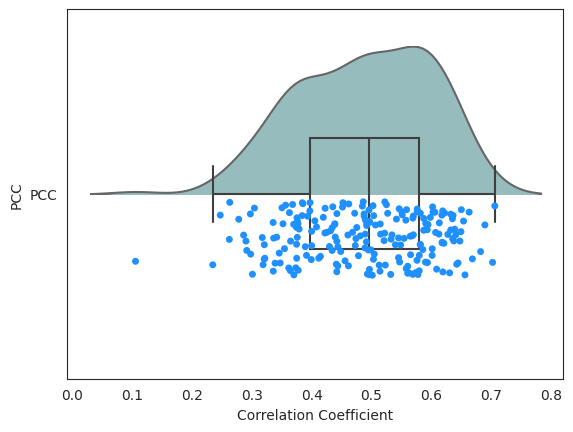

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('white')
palette = sns.cubehelix_palette(start=.5, rot=-.5, dark=0.3, light=0.7)
ax = sns.violinplot(y="PCC", x="Correlation Coefficient", data=correlation_df,
                    palette=palette,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="PCC", x="Correlation Coefficient", data=correlation_df, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(y="PCC", x="Correlation Coefficient", data=correlation_df, color='dodgerblue', ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('/scratch/project/stseq/Onkar/STimage_v1/Survival/TCGA-PCC.png', format='png', dpi=400)
plt.show()
correlation_df.to_csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/TCGA_PCC.csv")

In [11]:
print("Original", len(correlation_df))
print("Filtered", len(correlation_df[correlation_df["P-Value"]<0.01]))

Original 213
Filtered 213
